# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [54]:
import tensorflow as tf
import csv
import numpy as np
import os
import pandas as pd
from PIL import Image
from keras import Model
from keras.applications.mobilenet import MobileNet,preprocess_input
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,Callback
from keras.layers import Conv2D,Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Change directory

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
os.getcwd()

'/content'

In [14]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Advanced CV/ACV')

### Load the training data from train.csv file

In [17]:
train = pd.read_csv('train_labels.csv')

In [18]:
train.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [19]:
print(train.shape)

(173, 8)


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [20]:
IMAGE_SIZE = 128

**Unzip the images**

In [24]:
!unrar x "//content/drive/My Drive/Colab Notebooks/Advanced CV/ACV/images_racoon.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from //content/drive/My Drive/Colab Notebooks/Advanced CV/ACV/images_racoon.rar

Creating    images                                                    OK
Creating    images/images                                             OK
Extracting  images/images/raccoon-1.jpg                                    0%  OK 
Extracting  images/images/raccoon-10.jpg                                   0%  OK 
Extracting  images/images/raccoon-100.jpg                                  0%  OK 
Extracting  images/images/raccoon-101.jpg                                  1%  OK 
Extracting  images/images/raccoon-102.jpg                                  1%  OK 
Extracting  images/images/raccoon-103.jpg                                  2%  OK 
Extracting  images/images/raccoon-104.jpg                                  2%  OK 
Extracting  images/images/raccoon-105.jpg        

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [46]:
import csv
with open('train_labels.csv', 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader,None)
    for i, row in enumerate(reader):
               
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!=0)&(j!=3)):
              row[j] = int(r)
              
        path,width, height,class_,xmin,ymin,xmax,ymax = row  
        paths.append(path)
        coords[i, 0] = xmin * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i, 1] = ymin * IMAGE_SIZE / height # Normalize bounding box by image size
        coords[i, 2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i, 3] = ymax* IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [57]:
import cv2

In [66]:
batch_images = np.zeros((len(paths),IMAGE_SIZE,IMAGE_SIZE,3),dtype =np.float32)
for i,fil in enumerate(paths):
  print(i,fil)
  img = Image.open('images/'+fil)
  img = img.resize((IMAGE_SIZE,IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img,dtype= np.float32))

0 raccoon-17.jpg
1 raccoon-11.jpg
2 raccoon-63.jpg
3 raccoon-63.jpg
4 raccoon-60.jpg
5 raccoon-69.jpg
6 raccoon-180.jpg
7 raccoon-200.jpg
8 raccoon-141.jpg
9 raccoon-19.jpg
10 raccoon-84.jpg
11 raccoon-124.jpg
12 raccoon-182.jpg
13 raccoon-111.jpg
14 raccoon-91.jpg
15 raccoon-79.jpg
16 raccoon-93.jpg
17 raccoon-20.jpg
18 raccoon-42.jpg
19 raccoon-139.jpg
20 raccoon-58.jpg
21 raccoon-71.jpg
22 raccoon-183.jpg
23 raccoon-1.jpg
24 raccoon-169.jpg
25 raccoon-82.jpg
26 raccoon-4.jpg
27 raccoon-101.jpg
28 raccoon-10.jpg
29 raccoon-166.jpg
30 raccoon-184.jpg
31 raccoon-38.jpg
32 raccoon-120.jpg
33 raccoon-142.jpg
34 raccoon-149.jpg
35 raccoon-51.jpg
36 raccoon-43.jpg
37 raccoon-123.jpg
38 raccoon-66.jpg
39 raccoon-9.jpg
40 raccoon-178.jpg
41 raccoon-47.jpg
42 raccoon-167.jpg
43 raccoon-54.jpg
44 raccoon-77.jpg
45 raccoon-155.jpg
46 raccoon-89.jpg
47 raccoon-153.jpg
48 raccoon-179.jpg
49 raccoon-115.jpg
50 raccoon-64.jpg
51 raccoon-56.jpg
52 raccoon-44.jpg
53 raccoon-39.jpg
54 raccoon-26.jpg
5

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [96]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [97]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [93]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [100]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

In [101]:
model.fit(batch_images,coords,epochs=30,batch_size=32,verbose=1)

Epoch 1/30
6/6 [==============================] - 2s 278ms/step - loss: 4017.4753 - IoU: 0.0902
Epoch 2/30
6/6 [==============================] - 2s 284ms/step - loss: 752.9630 - IoU: 0.4295
Epoch 3/30
6/6 [==============================] - 2s 286ms/step - loss: 447.1223 - IoU: 0.5770
Epoch 4/30
6/6 [==============================] - 2s 284ms/step - loss: 599.5827 - IoU: 0.5368
Epoch 5/30
6/6 [==============================] - 2s 283ms/step - loss: 342.9472 - IoU: 0.6237
Epoch 6/30
6/6 [==============================] - 2s 278ms/step - loss: 192.0638 - IoU: 0.6655
Epoch 7/30
6/6 [==============================] - 2s 281ms/step - loss: 202.6633 - IoU: 0.6502
Epoch 8/30
6/6 [==============================] - 2s 282ms/step - loss: 161.7524 - IoU: 0.7107
Epoch 9/30
6/6 [==============================] - 2s 282ms/step - loss: 120.2402 - IoU: 0.7514
Epoch 10/30
6/6 [==============================] - 2s 284ms/step - loss: 116.7701 - IoU: 0.7737
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

In [102]:
testimage = './images/raccoon-198.jpg'
unscaledtest = cv2.imread(testimage)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [103]:
height,width,_ = unscaledtest.shape
image = cv2.resize(unscaledtest, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [105]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

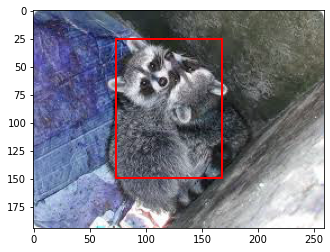

In [108]:
x0 = int(region[0] * width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * height / IMAGE_SIZE)

x1 = int((region[2]) * width / IMAGE_SIZE)
y1 = int((region[3]) * height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaledtest)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()